# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: 323746016 205633845

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

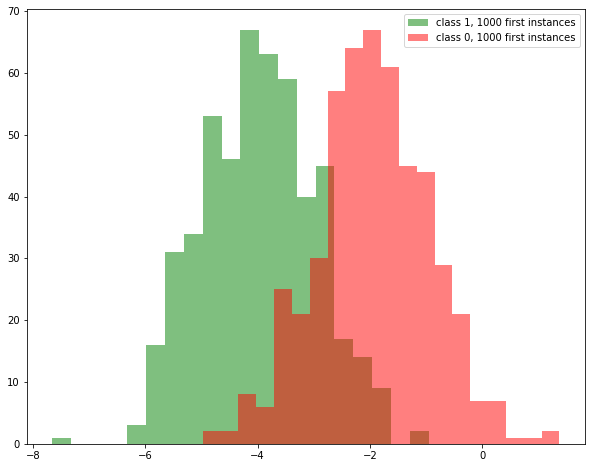

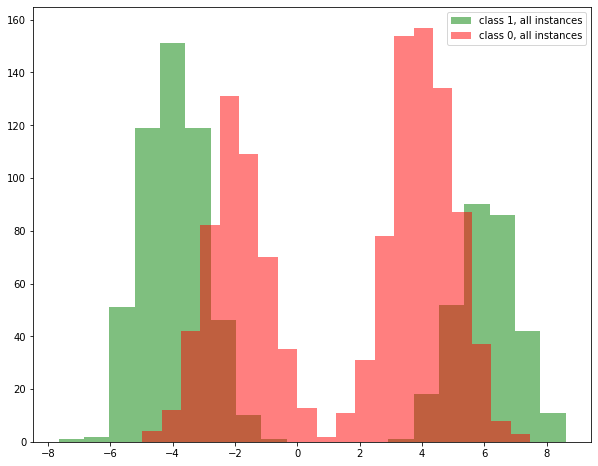

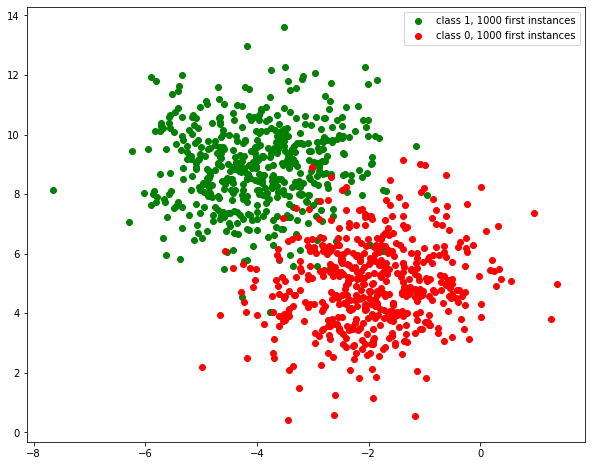

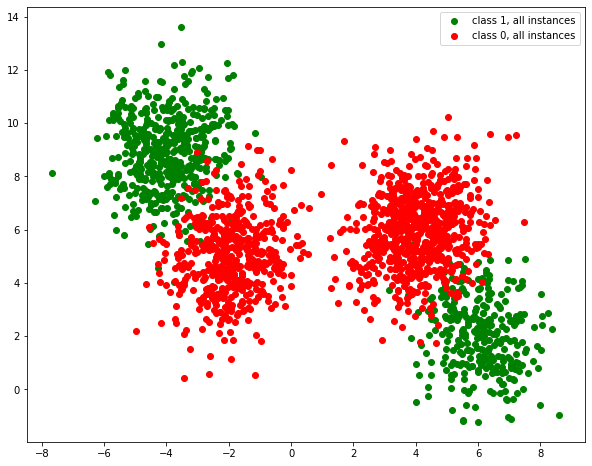

In [4]:
training_1000_set = X_training[0:1000, : ]
y_1000_set = y_training[0:1000]

training_set_class1 = X_training[np.where(y_training == 1)]
training_set_class0 = X_training[np.where(y_training == 0)]
training_1000_set_class1 = training_1000_set[np.where(y_1000_set == 1)]
training_1000_set_class0 = training_1000_set[np.where(y_1000_set == 0)]


plt.hist(training_1000_set_class1[:, 0], 20, facecolor='green', alpha=0.5, label = "class 1, 1000 first instances")
plt.hist(training_1000_set_class0[:, 0], 20, facecolor='red', alpha=0.5, label = "class 0, 1000 first instances")
plt.legend()
plt.show()

plt.hist(training_set_class1[:, 0], 20, facecolor='green', alpha=0.5, label = "class 1, all instances")
plt.hist(training_set_class0[:, 0], 20, facecolor='red', alpha=0.5, label = "class 0, all instances")
plt.legend()
plt.show()

plt.scatter(training_1000_set_class1[:, 0], training_1000_set_class1[:, 1] , color = "green", label = "class 1, 1000 first instances")
plt.scatter(training_1000_set_class0[:, 0], training_1000_set_class0[:, 1] , color = "red", label = "class 0, 1000 first instances")
plt.legend()
plt.show()



plt.scatter(training_set_class1[:, 0], training_set_class1[:, 1] , color = "green", label = "class 1, all instances")
plt.scatter(training_set_class0[:, 0], training_set_class0[:, 1] , color = "red", label = "class 0, all instances")
plt.legend()
plt.show()



## Logistic Regression

(20 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [5]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
 
        """
        X = np.column_stack((np.ones(len(X)), X))   #add bias of ones
        
        
        np.random.seed(self.random_state)
        theta = np.random.random(size = X.shape[1]) 
        last_cost = 1
        self.cost_list = []
        
        for i in range(self.n_iter):
            #J_history.append(self.compute_cost(X,y,theta))   #1
            
            #gradient = np.dot(X.T, (self.hypothesis(X, theta) - y)) / y.size  #2
            #self.theta -= self.eta * gradient
            
            h_X_vector = self.sigmoid(np.dot(X, theta))
            
            cost = self.compute_cost(h_X_vector, y)
            self.cost_list.append(cost)
            
            if (i > 0) and last_cost - cost < self.eps:
                break
            
            gradient = np.dot(X.T, h_X_vector - y)  #check again
            
            theta = theta - self.eta * gradient
            last_cost = cost
                
        self.theta = theta
        
        
    def compute_cost(self, h_X_vector, y):
        m = len(y)
        cost_vector = np.subtract(-y * np.log(h_X_vector), (1 - y) * np.log(1 - h_X_vector));
        return np.sum(cost_vector) / m
    
    def sigmoid(self,z): 
        return 1/(1 + np.exp(-z))
        
    def predict(self, X):
        X = np.column_stack((np.ones(len(X)), X))
        prediction_vector = self.sigmoid(np.dot(X, self.theta))
        #print(prediction_vector)
        prediction_vector[prediction_vector > 0.5] = 1
        prediction_vector[prediction_vector <= 0.5] = 0
        
        return prediction_vector

## Cross Validation

(10 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [6]:
def accuracy(prediction_classes, actual_classes):
    difference = prediction_classes - actual_classes
    
    return 1.0 - (float(np.count_nonzero(difference)) / len(difference))

In [7]:
#### Your code here ####
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

training_set_copy = training_set[['x1', 'x2', 'y']].values
np.random.shuffle(training_set_copy)



x_training_shuffeled, y_training_shuffeled = training_set_copy[:, :2] , training_set_copy[:, -1]

size_of_set = (int)(len(x_training_shuffeled) / 5)
best_eta, best_eps = 0,0
best_accuracy = 0
j = 0

for eta in etas:
    for eps in epss:
        curr_accuracy = 0
        for i in range(5):
            start_data_to_select, end_data_to_select = i * size_of_set, min((i+1)* size_of_set, len(x_training_shuffeled))
    
            x_temp_val = x_training_shuffeled[start_data_to_select : end_data_to_select: , :]
            y_temp_val = y_training_shuffeled[start_data_to_select : end_data_to_select]

            x_temp_train = np.concatenate((x_training_shuffeled[0 : start_data_to_select , :], x_training_shuffeled[end_data_to_select : len(x_training_shuffeled) , :]), 0)
            y_temp_train = np.concatenate((y_training_shuffeled[0 : start_data_to_select], y_training_shuffeled[end_data_to_select : len(y_training_shuffeled)]), 0)
    
            logisticRegre = LogisticRegressionGD(eta = eta, eps = eps)
            
            logisticRegre.fit(x_temp_train, y_temp_train)
            curr_accuracy += accuracy(logisticRegre.predict(x_temp_val), y_temp_val)
            
        if curr_accuracy > best_accuracy:  #does not divide by 5: if x > y then x / 5 > y / 5
            best_accuracy = curr_accuracy
            best_eta, best_eps = eta, eps



## Normal distribution pdf

(5 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [8]:
print(best_eta, best_eps)

5e-05 1e-06


In [9]:
#### Your code here ####
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    scalar = 1 /(sigma * np.sqrt(2 * np.pi))
    exponent = -0.5 * ((data - mu) / sigma) ** 2
    
    return scalar * np.exp(exponent)

## Expectation Maximization

(20 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [10]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01, random_state=1, mus = [], sigmas = [], mixing_proportions = []):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.mus = [None] * k
        self.sigmas = [None] * k
        self.mixing_proportions = mixing_proportions 
        

  # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        data_split = np.split(data, self.k)
        
        for j in range(self.k):
            self.mus[j] = np.mean(data_split[j])
            self.sigmas[j] = np.std(data_split[j])
        
       
        self.mixing_proportions = np.full(self.k, 1 / self.k)
        
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        responsibilities_before_division = np.zeros((len(data),self.k))
        
        
        for j in range(self.k):
            responsibilities_before_division[: , j] =  self.mixing_proportions[j] * norm_pdf(data, self.mus[j], self.sigmas[j])
            
        self.responsibilities_before_division = responsibilities_before_division
        self.responsibilities =  (responsibilities_before_division.T / np.sum(responsibilities_before_division, axis=1)).T
    
    
    def maximization(self, data):  
        """
        M step - updating distribution params
        """
       
        N_length_of_data = len(data)
        
        sum_of_responsabilities = np.sum(self.responsibilities, axis = 0)
        
        for j in range(self.k):
            self.mixing_proportions[j] = sum_of_responsabilities[j] / N_length_of_data
            
            scalar = 1 / (sum_of_responsabilities[j])
           
            self.mus[j] = scalar * np.dot(self.responsibilities[:, j].T, data)
            
            sigma_squared = scalar * np.dot(self.responsibilities[:, j].T, np.square(data - self.mus[j]))
            
            self.sigmas[j] = np.sqrt(sigma_squared)
        
        
            
    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        
        self.cost_list = []
        last_cost = 1
        
        for i in range(self.n_iter):
            
            self.expectation(data)
            cost = np.sum(-np.log(np.sum(self.responsibilities_before_division, axis = 1)))
            
            self.maximization(data)
            
            self.cost_list.append(cost)
            
            if (i > 0) and last_cost - cost < self.eps:
                break
            
            last_cost = cost

    def get_dist_params(self):
    
        return self.mixing_proportions, self.mus, self.sigmas
    

## Naive Bayes

(20 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [11]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, EMs_by_class = {}, priors_by_class = [None] * 2):
        self.k = k
        self.EMs_by_class = EMs_by_class
        self.priors_by_class = priors_by_class
        
    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        num_of_features = X.shape[1]  
        EMs_by_class_0 = [None] * num_of_features
        EMs_by_class_1 = [None] * num_of_features
                
        data_class_0 = X[np.where(y == 0)]
        data_class_1 = X[np.where(y == 1)]
        
        
        
        for i in range(num_of_features):   
            data_by_feature_and_class0 = data_class_0[:, i]  
            data_by_feature_and_class1 = data_class_1[:, i]
          
            EM0 = EM(k = self.k)
            EM0.fit(data_by_feature_and_class0)
            
            EM1 = EM(k = self.k)
            EM1.fit(data_by_feature_and_class1)
            
            EMs_by_class_0[i] = EM0
            EMs_by_class_1[i] = EM1
            
        self.EMs_by_class = {'0' : EMs_by_class_0, '1' : EMs_by_class_1}
        self.priors_by_class[0] = float(len(np.where(y == 0)) / len(y))
        self.priors_by_class[1] = float(len(np.where(y == 1)) / len(y))
        
        
    def get_prior_by_class(self, specific_class):
        """
        Returns the prior porbability of the class according to the dataset distribution.
        """
        return self.priors_by_class[specific_class]
    
    
    def get_instances_likelihoods(self, X, specific_class):
        """
        Returns the likelihhods porbability of the instance under the class according to the dataset distribution.
        """
        relevant_Ems = self.EMs_by_class[f'{specific_class}']
        
        mixing_proportions1, mus_feature1, sigmas_feature1 = np.array(relevant_Ems[0].get_dist_params())
        mixing_proportions2, mus_feature2, sigmas_feature2 = np.array(relevant_Ems[1].get_dist_params())
        
        
        probabilitys_1 = np.array([mixing_proportions1[j] * norm_pdf(X[:, 0], mus_feature1[j], sigmas_feature1[j]) for j in range(self.k)])
        gauss_of_1_indexs = np.argmax(probabilitys_1, axis = 0)
        
        
        probabilitys_2 = np.array([mixing_proportions2[j] * norm_pdf(X[:, 1], mus_feature2[j], sigmas_feature2[j]) for j in range(self.k)])
        gauss_of_2_indexs = np.argmax(probabilitys_2, axis = 0)
     
        
        return norm_pdf(X[:,0], mus_feature1[gauss_of_1_indexs], sigmas_feature1[gauss_of_1_indexs]) * (norm_pdf(X[:, 1], mus_feature2[gauss_of_2_indexs], sigmas_feature2[gauss_of_2_indexs]))    
    
    
    def get_instances_posterior(self, X, specific_class):
        """
        Returns the posterior porbability of the instance under the class according to the dataset distribution.
        * Ignoring p(x)
        """
        
        return self.get_instances_likelihoods(X, specific_class) * self.get_prior_by_class(specific_class)
    
    def predict(self, X):
        prediction_vector = [None] * len(X)
        prediction_class_1 = self.get_instances_posterior(X, 1)
        prediction_class_0 = self.get_instances_posterior(X, 0) 
            
        prediction_vector = np.where(prediction_class_1 >= prediction_class_0, 1, 0)
       
        return prediction_vector
                                                                                             

## Model evaluation

(10 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points

The accuracy of the Naive bayes training the first 1000 instances in the train set 
 and testing on the first 500 instances on the dataset is: 
0.942

The accuracy of the Logistic regression training the first 1000 instances in the train set 
 and testing on the first 500 instances on the dataset is: 
0.938


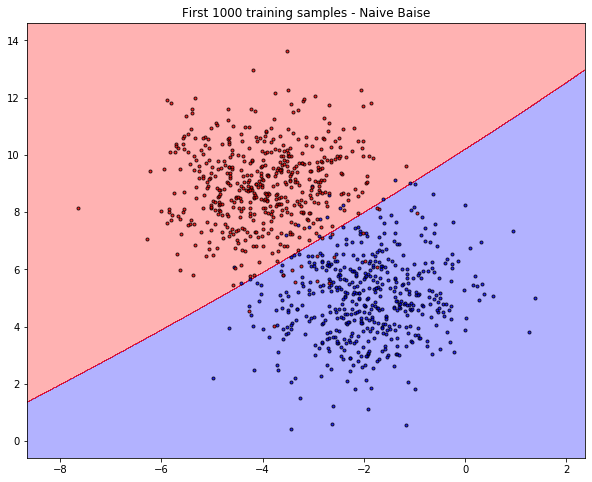

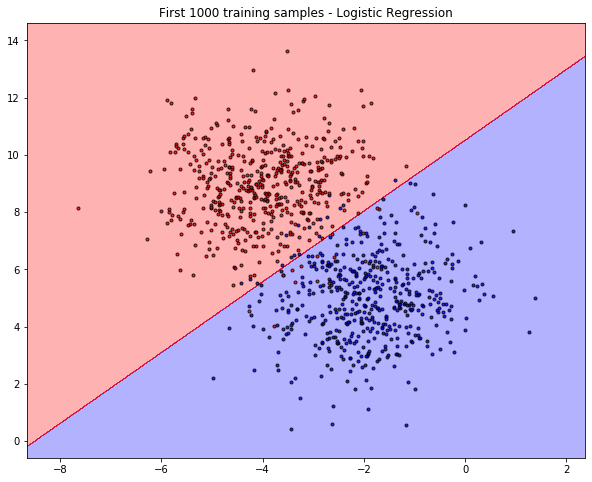

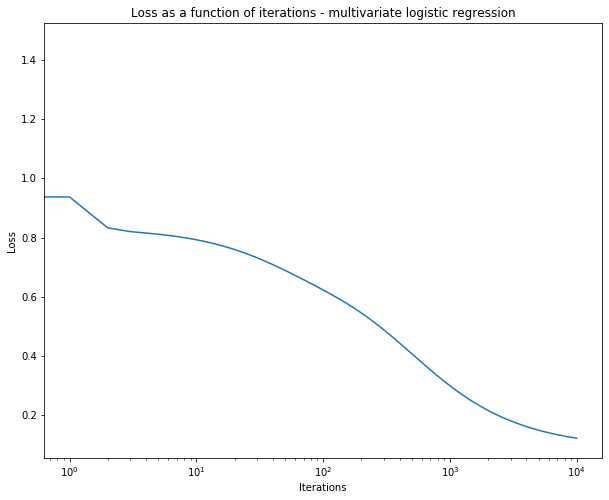

The accuracy of the Naive bayes training the first all instances in the train set 
 and testing on the test set instancesis: 
0.897

The accuracy of the Logistic regression training the first 1000 instances in the train set 
 and testing on the first 500 instances on the dataset is: 
0.804


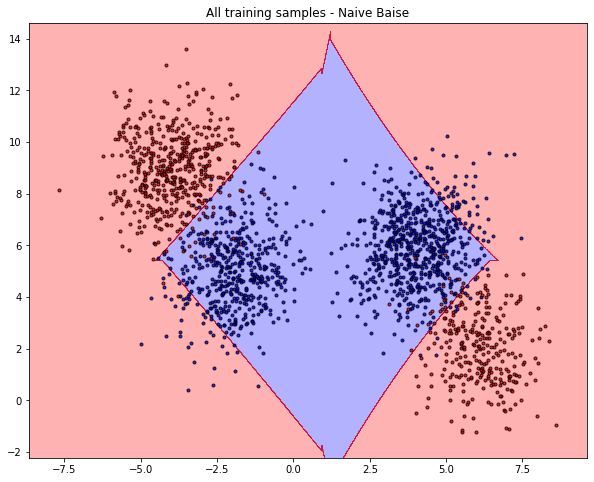

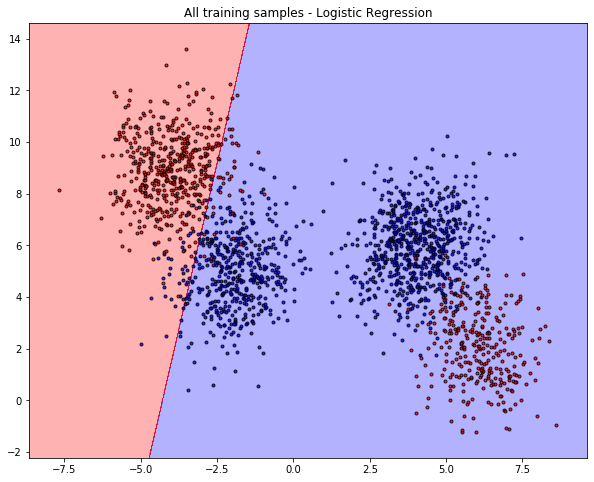

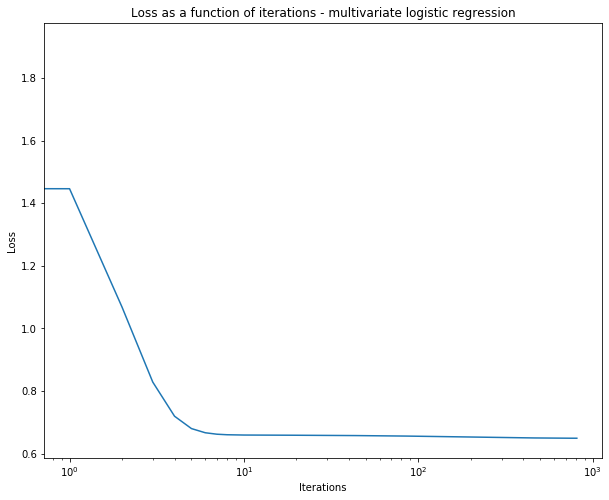

In [12]:
lr_1000 = LogisticRegressionGD(eta = best_eta, eps = best_eps)
Nbg_one_gaussian_1000 = NaiveBayesGaussian(k = 1)

test_500_set = X_test[0:500, : ]
y_test_500_set = y_test[0:500]

lr_1000.fit(training_1000_set, y_1000_set)
Nbg_one_gaussian_1000.fit(training_1000_set, y_1000_set)

print(f"The accuracy of the Naive bayes training the first 1000 instances in the train set \n and testing on the first 500 instances on the dataset is: \n{accuracy(Nbg_one_gaussian_1000.predict(test_500_set), y_test_500_set)}")
print(f"\nThe accuracy of the Logistic regression training the first 1000 instances in the train set \n and testing on the first 500 instances on the dataset is: \n{accuracy(lr_1000.predict(test_500_set), y_test_500_set)}")

plot_decision_regions(training_1000_set, y_1000_set, Nbg_one_gaussian_1000)
plt.title('First 1000 training samples - Naive Baise')
plt.show()

plot_decision_regions(training_1000_set, y_1000_set, lr_1000)
plt.title('First 1000 training samples - Logistic Regression')
plt.show()

plt.plot(np.arange(len(lr_1000.cost_list)), lr_1000.cost_list)
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss as a function of iterations - multivariate logistic regression')
plt.show()

lr = LogisticRegressionGD(eta = best_eta, eps = best_eps)
Nbg_two_gaussian = NaiveBayesGaussian(k = 2)


lr.fit(X_training, y_training)
Nbg_two_gaussian.fit(X_training, y_training)

print(f"The accuracy of the Naive bayes training the first all instances in the train set \n and testing on the test set instancesis: \n{accuracy(Nbg_two_gaussian.predict(X_test), y_test)}")
print(f"\nThe accuracy of the Logistic regression training the first 1000 instances in the train set \n and testing on the first 500 instances on the dataset is: \n{accuracy(lr.predict(X_test), y_test)}")

plot_decision_regions(X_training, y_training, Nbg_two_gaussian)
plt.title('All training samples - Naive Baise')
plt.show()

plot_decision_regions(X_training, y_training, lr)
plt.title('All training samples - Logistic Regression')
plt.show()

plt.plot(np.arange(len(lr.cost_list)), lr.cost_list)
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss as a function of iterations - multivariate logistic regression')
plt.show()




## Open question

(7 points) 

Will Full Bayes get better results comparing to Naive Bayes on the following dataset? Explain. 

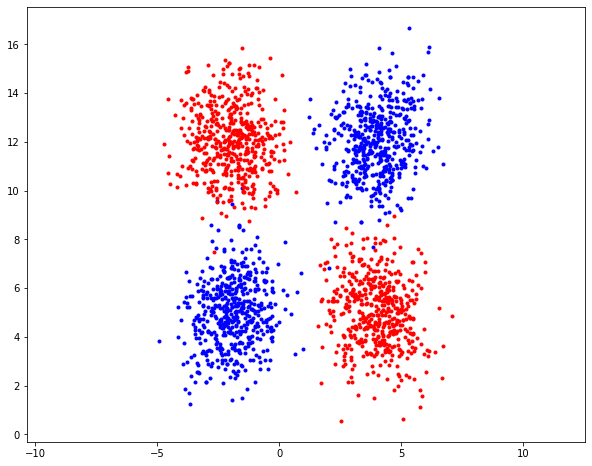

In [13]:
mean = [[-2,5], [-2, 12], [4, 12], [4, 5]]
cov = [[[1,0.2],[0.2,2]], [[1,0],[0,2]], [[1,0.2],[0.2,2]], [[1,-0.2],[-0.2,2]]]
x1 = []
x2 = []
y = []
size = [500, 500, 500, 500]
c = ['b', 'r']
for i in range(4):
    xx1,xx2 = np.random.multivariate_normal(mean[i],cov[i],size[i]).T
    x1.extend(xx1)
    x2.extend(xx2)
    y.extend([i%2] * size[i])
    plt.scatter(xx1,xx2, marker='.', c=c[i%2])
plt.axis('equal')
plt.show()

#### Your answer here ####


i think that Full Bayes will get better results comparing to Naive Bayes on the following dataset, because you can see that
the data given the red or blue class by feature looks dependent.
for example if you look at the data that is in the red classwhenever X1 < 0 then X2 > 8.5 and whenever X1 > 0 then X2 < 8.5
(approximitally) and you can see the same for the instaces in the blue class just the opposite.
therefore in the instances given the class it looks like the feature distribution is depentent beetween the two features.
in comparison to our data which the dependency is not as concrete.